In [1]:
%matplotlib inline
import os, sys, inspect, warnings
curr_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) # script directory
main_dir = '/'.join(curr_dir.split('/')[:-1])
sub_dir = os.path.join(main_dir, 'RGCPD/')
# core_pp = os.path.join(main_dir, 'RGCPD/core')
if main_dir not in sys.path:
    sys.path.append(main_dir)
    sys.path.append(sub_dir)
import numpy as np
import math
# from collections import Counter
# import statsmodels.api as sm 
import pandas as pd 
import math
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (18.0, 9.0)
import itertools as it
import pywt as wv
from scipy.fftpack import fft
from copy import deepcopy
# from statsmodels.tsa.arima_process import  arma_generate_sample, ArmaProcess
from pprint import pprint as pp 
from pandas.plotting import register_matplotlib_converters
from RGCPD import RGCPD
from RGCPD import BivariateMI
from df_ana_class import DataFrameAnalysis, VisualizeAnalysis
import core_pp
from pathlib import Path
from plot_signal_decomp import *
from  plot_coeffs import *
# from visualize_cwt import *
import wave_ana as wa 
register_matplotlib_converters()
np.random.seed(12345)
plt.style.use('seaborn')

Could not import rpy package
Could not import r-package RCIT


# Extracting ERA5 data step

In [22]:
path_data = os.path.join(main_dir, 'data')
current_analysis_path = os.path.join(main_dir, 'Jier_analysis')
target= 3
target_path = os.path.join(path_data, 'tf5_nc5_dendo_80d77.nc')
precursor_path = os.path.join(path_data,'sst_1979-2018_2.5deg_Pacific.nc')
list_of_name_path = [(target, target_path), 
                    ('sst', precursor_path )]
list_for_MI = [BivariateMI(name='sst', func=BivariateMI.corr_map, 
                          kwrgs_func={'alpha':.0001, 'FDR_control':True}, 
                          distance_eps=700, min_area_in_degrees2=5)]
rg = RGCPD(list_of_name_path=list_of_name_path,
           list_for_MI=list_for_MI,
        #    start_end_TVdate=('06-01', '08-31'),
           path_outmain=os.path.join(main_dir,'Jier_analysis/Wavelet/'), verbosity=0)
rg.pp_precursors(detrend=True, anomaly=True, selbox=None)
rg.pp_TV()
rg.traintest(method='no_train_test_split')
rg.calc_corr_maps()
rg.cluster_list_MI()
# rg.get_ts_prec(precur_aggr=1)
rg.get_ts_prec()

original tfreq of imported response variable is converted to desired tfreq 10
Daily input freq
No train test split

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(320dp, 100%)


Getting MI timeseries
There are [2] regions in total (list of different splits)


In [3]:
Path('Wavelet/b2basis/').mkdir(parents=True, exist_ok=True)

Progress causal inference - traintest set 100%

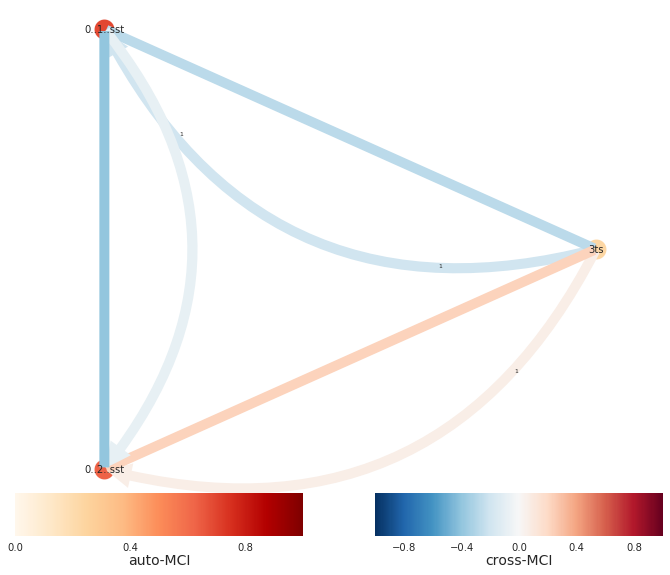

In [23]:
rg.PCMCI_df_data()
rg.PCMCI_get_links()
rg.df_MCIc
ax = rg.PCMCI_plot_graph()
plt.savefig('Wavelet/b2basis/basis_plot_def_dates_10.png', dpi=120, bbox_inches='tight')
plt.show()

In [5]:
rg_data  = rg.df_data.loc[:,rg.df_data.columns[rg.df_data.dtypes != bool]]
rg_index = rg_data.index.levels[1]
if len(rg_data.columns[1:].tolist()) == 2:    
    prec1 = rg_data.iloc[:,1].values
    prec2 = rg_data.iloc[:,2].values
more_precursors = False 
if len(rg_data.columns[1:].tolist()) > 2:
    more_precursors = True
    prec_list = [rg_data.iloc[:,i]
      for i in range(1, len(rg_data.columns[1:].tolist())+1)
      if len(rg_data.columns[1:].tolist()) > 2 ]

target = rg_data.iloc[:,0].values

In [6]:
la8 = wa.create_least_asymmetric_filter(mode='dwt')
waves = ['db2', 'db3', 'db4', 'db8', 'sym2', 'sym4', 'sym8', la8]

# Example of signal reconstruction after wavelet transform and wavelet coefficients

Appropriate level is changed to  8


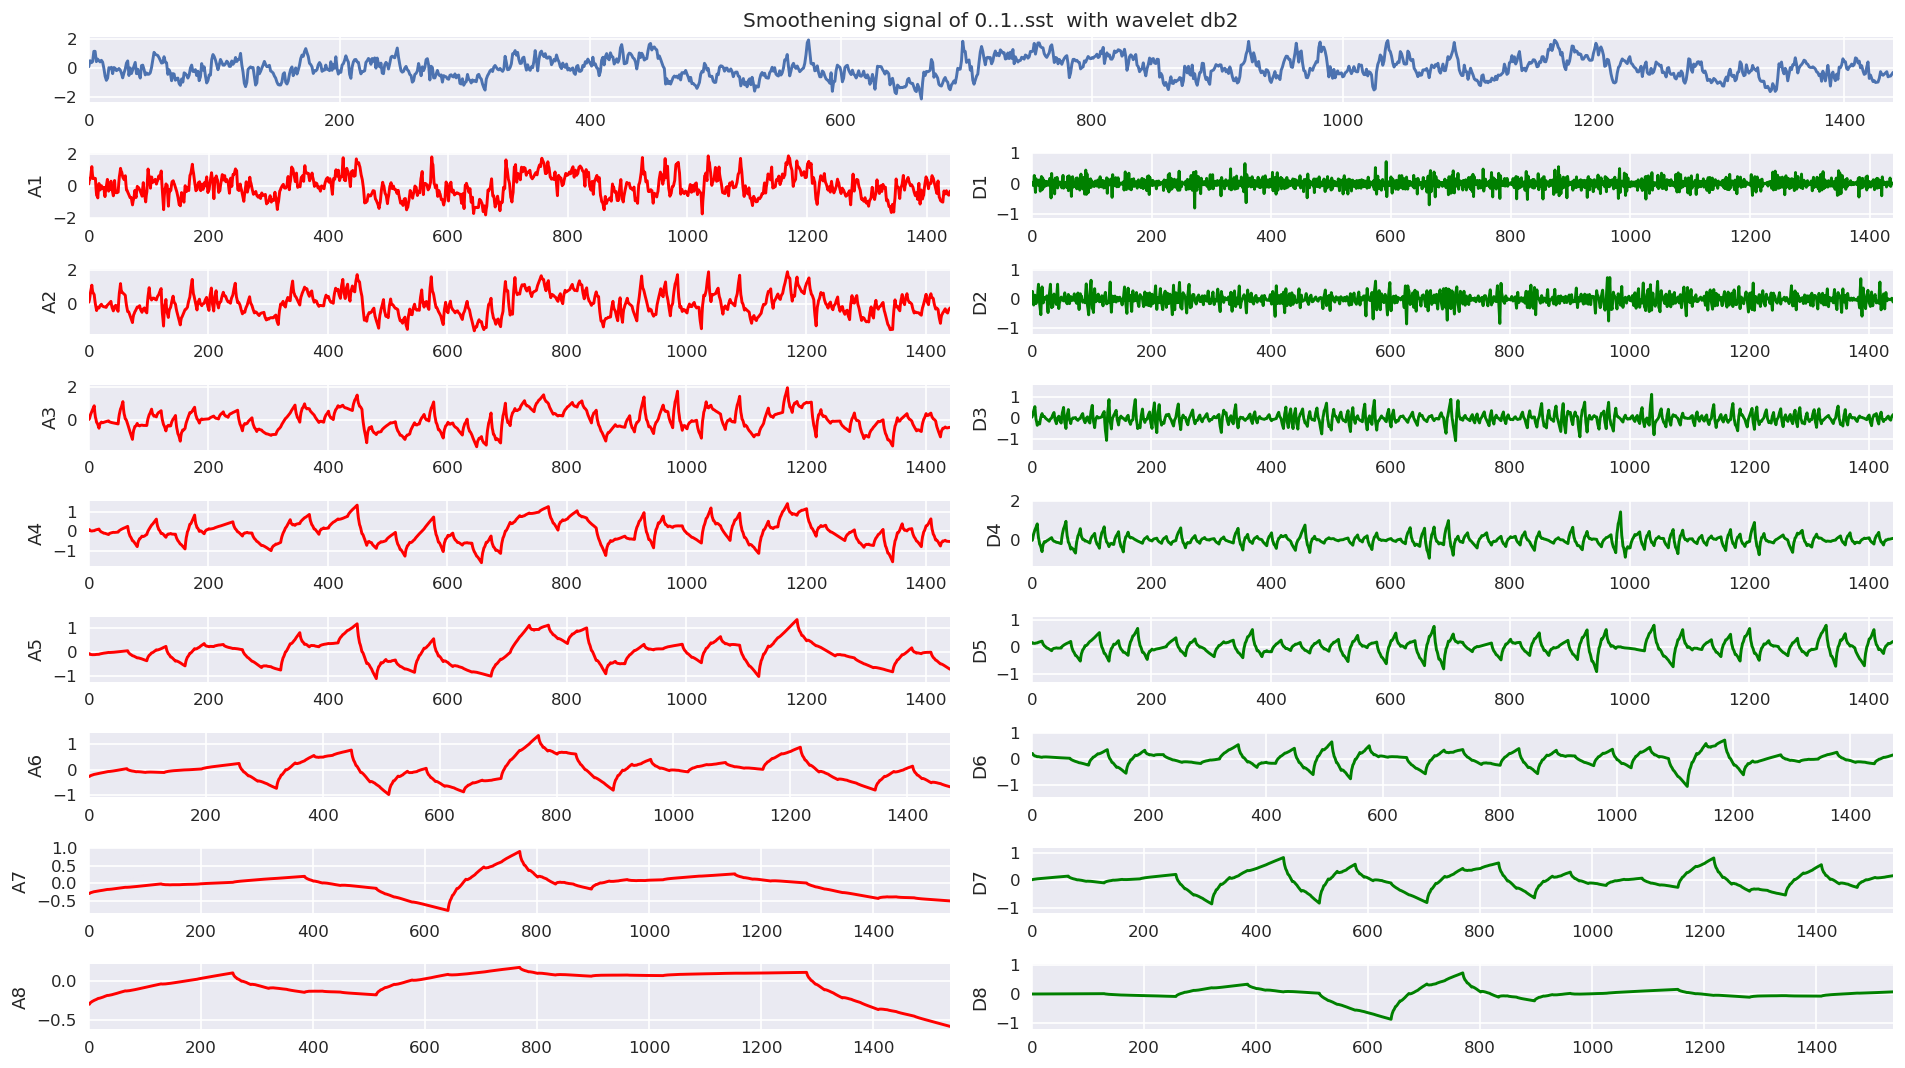

In [7]:
plot_signal_decomp(data=prec1, w=wv.Wavelet('db2'), mode=wv.Modes.periodic,
title=f"Smoothening signal of {rg_data.iloc[:,1].name}  with wavelet {wv.Wavelet('db2').name}", level=9)

Appropriate level is changed to  8


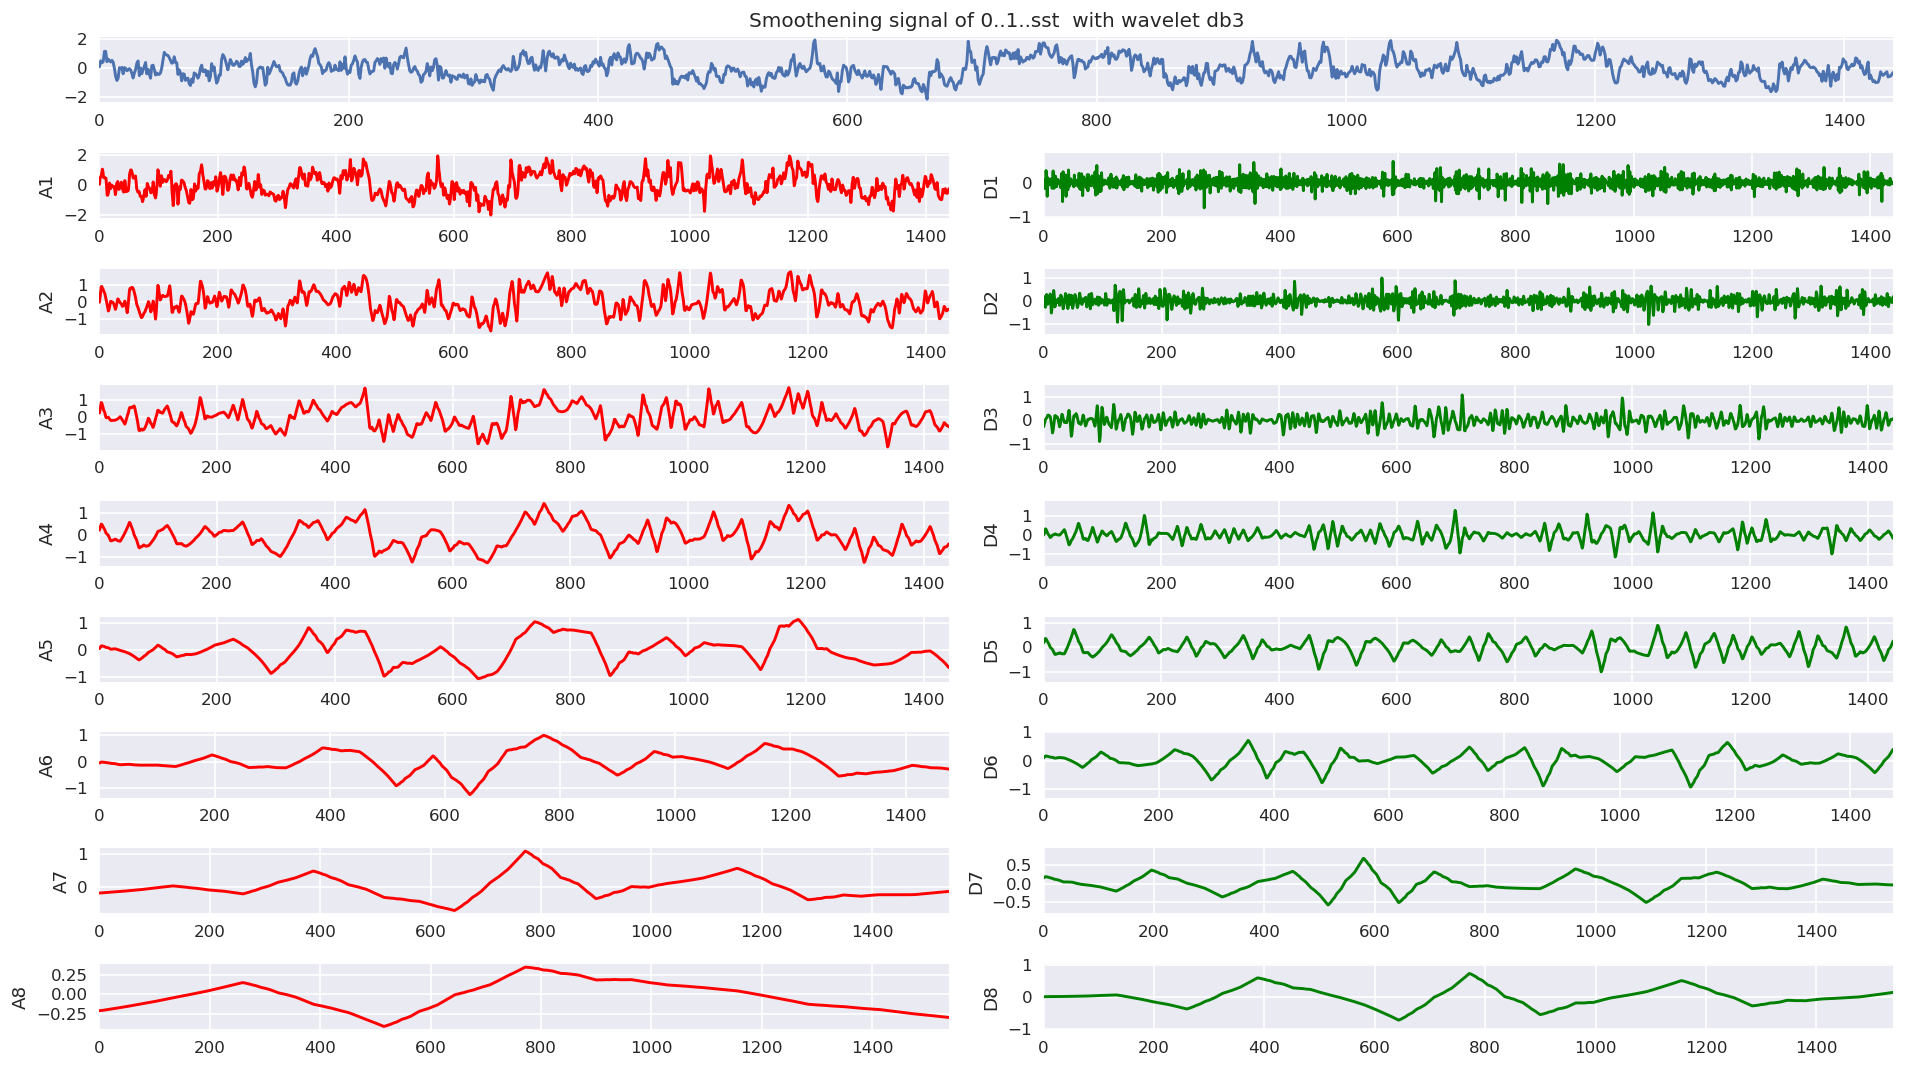

In [8]:
plot_signal_decomp(data=prec1, w=wv.Wavelet('db3'), mode=wv.Modes.periodic,
title=f"Smoothening signal of {rg_data.iloc[:,1].name}  with wavelet {wv.Wavelet('db3').name}", level=9)

Appropriate level is changed to  7


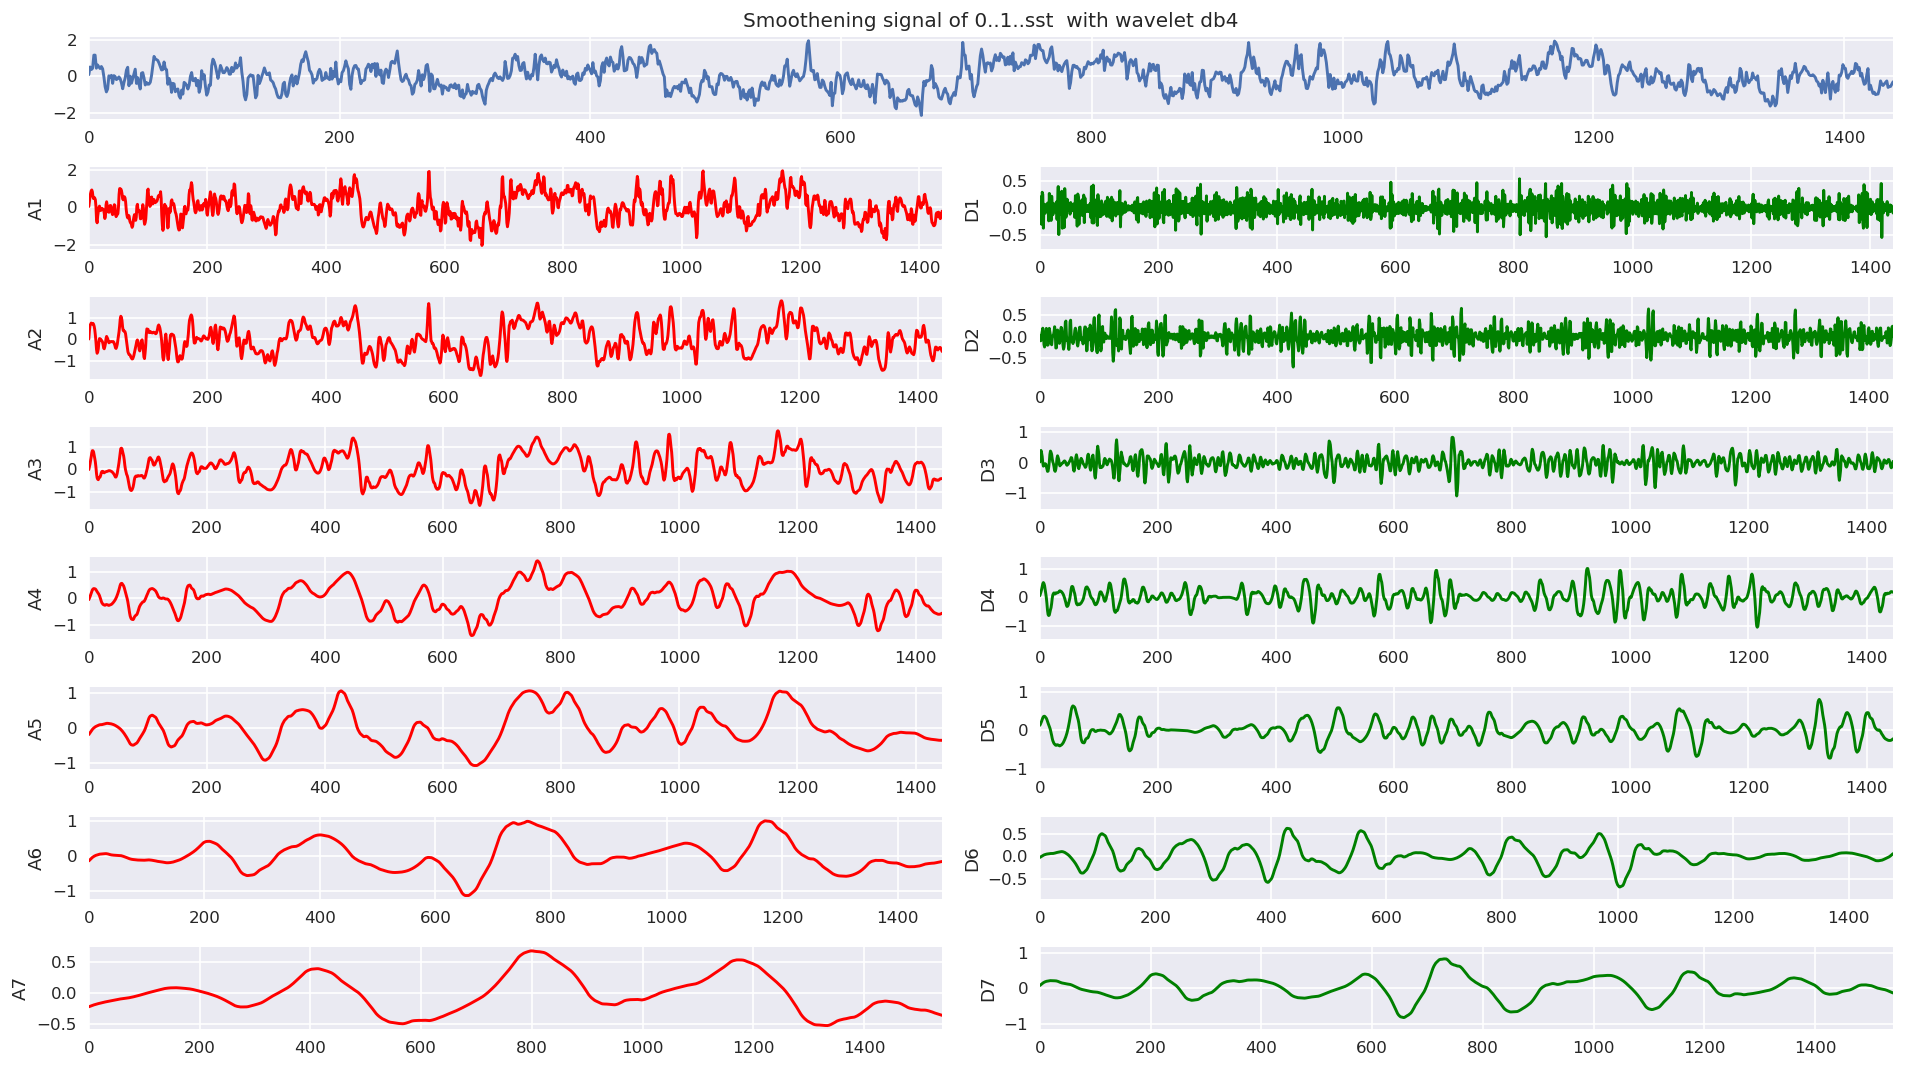

In [9]:
plot_signal_decomp(data=prec1, w=wv.Wavelet('db4'), mode=wv.Modes.periodic,
title=f"Smoothening signal of {rg_data.iloc[:,1].name}  with wavelet {wv.Wavelet('db4').name}", level=9)

Appropriate level is changed to  8


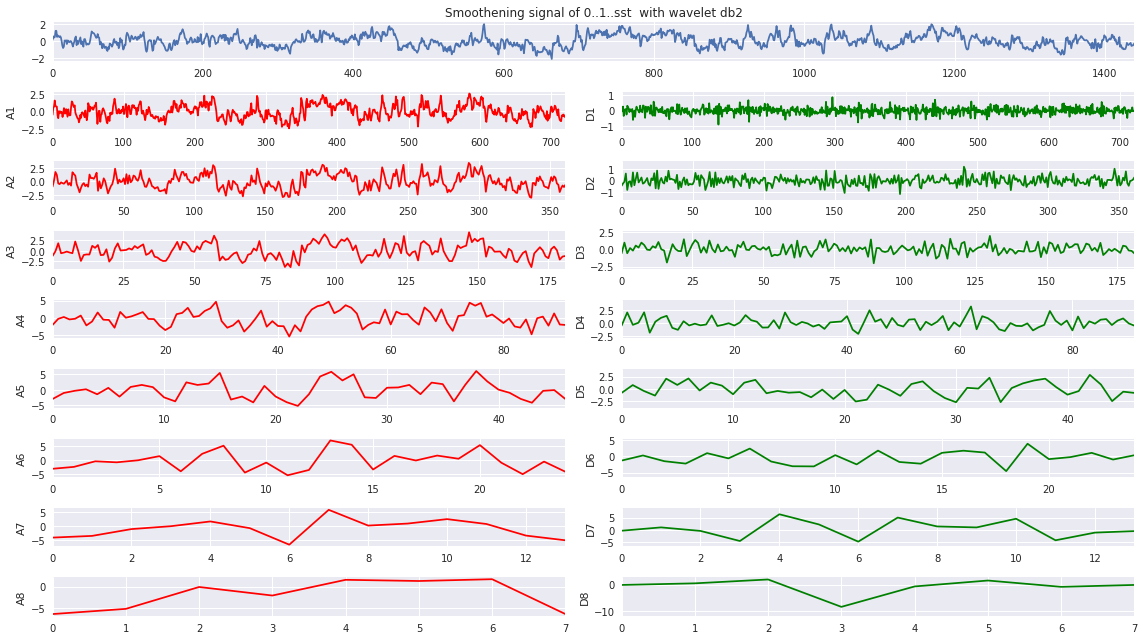

In [10]:
plot_coeffs(data=prec1, w=wv.Wavelet('db2'), mode=wv.Modes.periodic, 
title=f"Smoothening signal of {rg_data.iloc[:,1].name}  with wavelet {wv.Wavelet('db2').name}", level=9)

Appropriate level is changed to  8


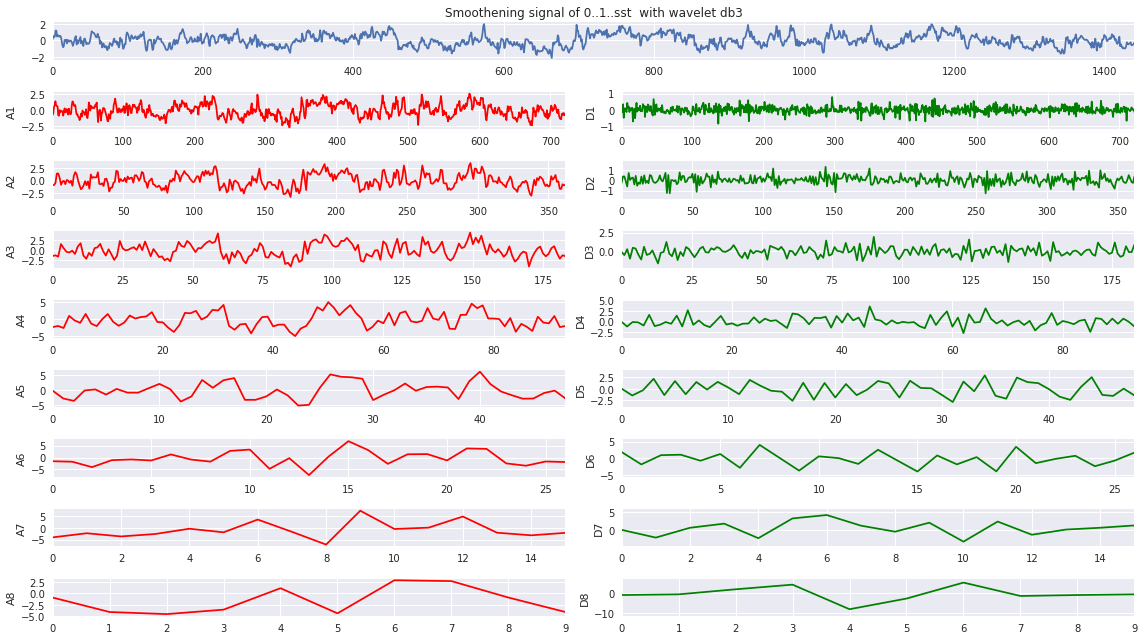

In [11]:
plot_coeffs(data=prec1, w=wv.Wavelet('db3'), mode=wv.Modes.periodic, 
title=f"Smoothening signal of {rg_data.iloc[:,1].name}  with wavelet {wv.Wavelet('db3').name}", level=9)

Appropriate level is changed to  7


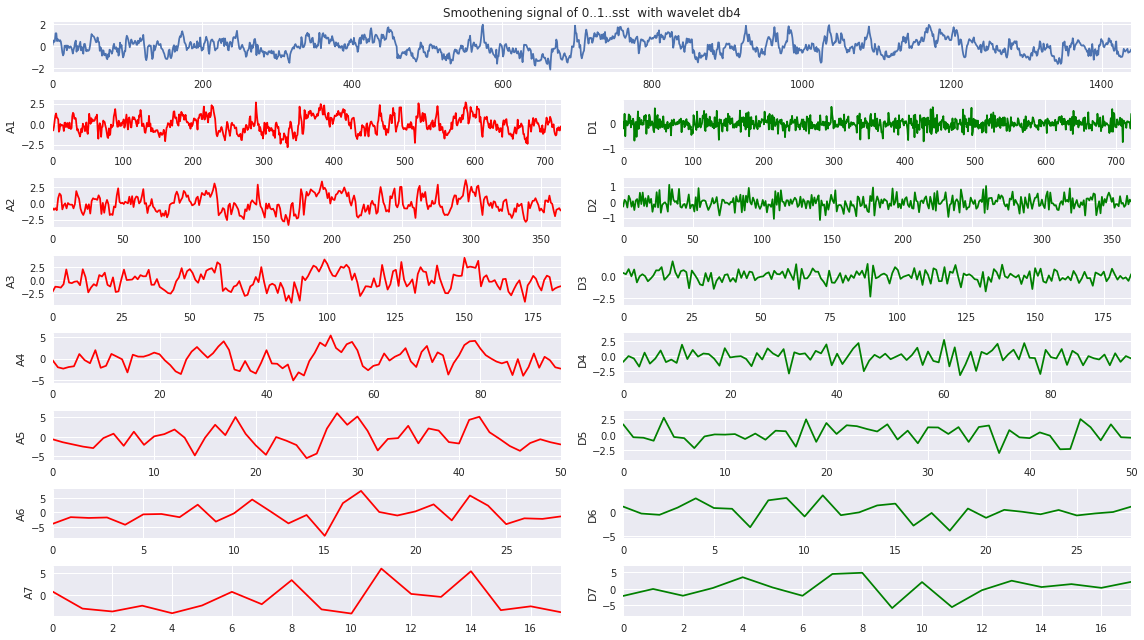

In [12]:
plot_coeffs(data=prec1, w=wv.Wavelet('db4'), mode=wv.Modes.periodic, 
title=f"Smoothening signal of {rg_data.iloc[:,1].name}  with wavelet {wv.Wavelet('db4').name}", level=9)

# DWT decomposition only using Details
## DB4, DB4 normalised does not capture signal well, not useful, LA8 captures it too well both peak estimation vs theoretical peak understimated 

In [13]:
def decompose_signal(data, w, mode, debug=False):
    assert isinstance(w, wv.Wavelet)
    cA, cD = [] , []
    s_prec  = data 
    for i in range(wv.dwt_max_level(len(data), w.dec_len)):
        s_prec, det  = wv.dwt(s_prec, w, mode=mode)
        cA.append(s_prec)
        cD.append(det)
    if debug:
        print(f'[DEBUG]')
        for i, value in enumerate(cD):
            print(f' Level {i} decomposition Length coefficient {value}')
    return cA, cD 

In [14]:
mci_peaks = []
for wave in waves: 
    obj_rgcpd = []    
    # prec1_pmatrix = []
    if wave == la8:
        cA, cD = decompose_signal(data=prec1, w=wave, mode=wv.Modes.periodic)
        cA_t, cD_t = decompose_signal(data=target, w=wave, mode=wv.Modes.periodic)
        Path('Wavelet/b2basis/prec1_aggr_10/' +wave.name).mkdir(parents=True, exist_ok=True)
    else:

        cA, cD = decompose_signal(data=prec1, w=wv.Wavelet(wave), mode=wv.Modes.periodic)
        cA_t, cD_t = decompose_signal(data=target, w=wv.Wavelet(wave), mode=wv.Modes.periodic)
        Path('Wavelet/b2basis/prec1_aggr_10/' +wv.Wavelet(wave).name).mkdir(parents=True, exist_ok=True)
    for i in range(0,len(cD)):    
        idx_lvl_t = pd.DatetimeIndex(pd.date_range(rg_index[0] ,rg_index[-1], periods=len(cD_t[i]) ).strftime('%Y-%m-%d') )
        idx_prec = pd.DatetimeIndex(pd.date_range(rg_index[0], rg_index[-1], periods=len(cD_t[i]) ).strftime('%Y-%m-%d') )
        dates = core_pp.get_subdates(dates=idx_lvl_t, start_end_date=('06-01', '08-31'), start_end_year=None, lpyr=False)
        full_time  = idx_lvl_t
        RV_time  = dates
        RV_mask = pd.Series(np.array([True if d in RV_time else False for d in full_time]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='RV_mask')
        trainIsTrue = pd.Series(np.array([True for _ in range(len(cD_t[i]))]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='TrainIsTrue')
        ts_ca1 = pd.Series(cD[i], index=pd.MultiIndex.from_product(([0], idx_prec)),name='p_1_lvl_'+ str(i)+'_dec')
        # ts_ca2= pd.Series(cD_2[i], index=pd.MultiIndex.from_product(([0], idx_prec)), name='p_2_lvl_'+str(i)+'_dec')
        ts_tca1 = pd.Series(cD_t[i], index=pd.MultiIndex.from_product(([0],idx_lvl_t)), name='3ts')
        df = pd.concat([ts_tca1, ts_ca1,   trainIsTrue, RV_mask], axis=1)
        rg.df_data = df
        rg.PCMCI_df_data(tau_max=2, pc_alpha=0.05)
        rg.PCMCI_get_links()
        rg.df_MCIc
        obj_rgcpd.append(deepcopy(rg.df_MCIc))
        # prec1_pmatrix.append(deepcopy(rg.pcmci_results_dict[0]['p_matrix']))
        rg.PCMCI_plot_graph()
        if wave == la8:
            plt.savefig('Wavelet/b2basis/prec1_aggr_10/'+wave.name+'/PCMCI_'+str(i)+'_level decom.png', dpi=120,  bbox_inches='tight')
        else:
            plt.savefig('Wavelet/b2basis/prec1_aggr_10/'+wave+'/PCMCI_'+str(i)+'_level decom.png', dpi=120,  bbox_inches='tight')
        plt.clf()
        # plt.show()
    mci_peaks.append(deepcopy(obj_rgcpd))

Progress causal inference - traintest set 100%

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [15]:
Path('Wavelet/b2basis/prec1_aggr_10/mci').mkdir(parents=True, exist_ok=True)
for i, wave in enumerate(waves):
        if wave == la8:
                _, cD = decompose_signal(data=prec1, w=wave, mode=wv.Modes.periodic)
        else:
                _, cD = decompose_signal(data=prec1, w=wv.Wavelet(wave), mode=wv.Modes.periodic)
        lag_0_1 = [lags.values[:,0][1] for _, lags in enumerate(mci_peaks[i])]
        x_as = np.arange(1, len(cD)+1)
        x_as = np.exp2(x_as)
        plt.figure(figsize=(19,8))
        plt.xticks(x_as)
        plt.plot(x_as, lag_0_1, label='0..1sst ')
        # plt.vlines(x_as[np.argmin(lag_0_1)], ymin=plt.ylim()[0], ymax=plt.ylim()[1],linestyles='dashed', label='MCI peak')
        if wave == la8:
                plt.title('Relation MCI on daily mean scale on lag 0 with wavelet '+wave.name)
        else:
                plt.title('Relation MCI on daily mean scale on lag 0 with wavelet '+wave)
        plt.xlabel('Scales in daily mean')
        plt.ylabel('MCI')
        plt.legend(loc=0)
        if wave == la8:
                plt.savefig('Wavelet/b2basis/prec1_aggr_10/mci/'+wave.name+'mci_peak.png', dpi=120,  bbox_inches='tight')
        else:
                plt.savefig('Wavelet/b2basis/prec1_aggr_10/mci/'+wave+'mci_peak.png', dpi=120,  bbox_inches='tight')
        plt.clf()

<Figure size 1368x576 with 0 Axes>

<Figure size 1368x576 with 0 Axes>

<Figure size 1368x576 with 0 Axes>

<Figure size 1368x576 with 0 Axes>

<Figure size 1368x576 with 0 Axes>

<Figure size 1368x576 with 0 Axes>

<Figure size 1368x576 with 0 Axes>

<Figure size 1368x576 with 0 Axes>

In [16]:
mci_peaks = []
for wave in waves:
    obj_rgcpd = []  
    # prec1_pmatrix = []
    if wave == la8:
        cA, cD = decompose_signal(data=prec2, w=wave, mode=wv.Modes.periodic)
        cA_t, cD_t = decompose_signal(data=target, w=wave, mode=wv.Modes.periodic)
        Path('Wavelet/b2basis/prec2_aggr_10/'+wave.name).mkdir(parents=True, exist_ok=True)
  
    else:
        cA, cD = decompose_signal(data=prec2, w=wv.Wavelet(wave), mode=wv.Modes.periodic)
        cA_t, cD_t = decompose_signal(data=target, w=wv.Wavelet(wave), mode=wv.Modes.periodic)
        Path('Wavelet/b2basis/prec2_aggr_10/'+wv.Wavelet(wave).name).mkdir(parents=True, exist_ok=True)
    for i in range(0,len(cD)):    
        idx_lvl_t = pd.DatetimeIndex(pd.date_range(rg_index[0] ,rg_index[-1], periods=len(cD_t[i]) ).strftime('%Y-%m-%d') )
        idx_prec = pd.DatetimeIndex(pd.date_range(rg_index[0], rg_index[-1], periods=len(cD_t[i]) ).strftime('%Y-%m-%d') )
        dates = core_pp.get_subdates(dates=idx_lvl_t, start_end_date=('06-01', '08-31'), start_end_year=None, lpyr=False)
        full_time  = idx_lvl_t
        RV_time  = dates
        RV_mask = pd.Series(np.array([True if d in RV_time else False for d in full_time]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='RV_mask')
        trainIsTrue = pd.Series(np.array([True for _ in range(len(cD_t[i]))]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='TrainIsTrue')
        ts_ca1 = pd.Series(cD[i], index=pd.MultiIndex.from_product(([0], idx_prec)),name='p_1_lvl_'+ str(i)+'_dec')
        # ts_ca2= pd.Series(cD_2[i], index=pd.MultiIndex.from_product(([0], idx_prec)), name='p_2_lvl_'+str(i)+'_dec')
        ts_tca1 = pd.Series(cD_t[i], index=pd.MultiIndex.from_product(([0],idx_lvl_t)), name='3ts')
        df = pd.concat([ts_tca1, ts_ca1,   trainIsTrue, RV_mask], axis=1)
        rg.df_data = df
        rg.PCMCI_df_data(tau_max=2, pc_alpha=0.05)
        rg.PCMCI_get_links()
        rg.df_MCIc
        obj_rgcpd.append(deepcopy(rg.df_MCIc))
        # prec1_pmatrix.append(deepcopy(rg.pcmci_results_dict[0]['p_matrix']))
        rg.PCMCI_plot_graph()
        if wave == la8:
            plt.savefig('Wavelet/b2basis/prec2_aggr_10/'+wave.name+'/PCMCI_'+str(i)+'_level decom.png', dpi=120,  bbox_inches='tight')
        else:
            plt.savefig('Wavelet/b2basis/prec2_aggr_10/'+wave+'/PCMCI_'+str(i)+'_level decom.png', dpi=120,  bbox_inches='tight')
        plt.clf()
    mci_peaks.append(deepcopy(obj_rgcpd))

Progress causal inference - traintest set 100%

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [17]:
Path('Wavelet/b2basis/prec2_aggr_10/mci').mkdir(parents=True, exist_ok=True)
for i, wave in enumerate(waves):
        if wave == la8:
                _, cD = decompose_signal(data=prec2, w=wave, mode=wv.Modes.periodic)
        else:
                _, cD = decompose_signal(data=prec2, w=wv.Wavelet(wave), mode=wv.Modes.periodic)
        lag_0_1 = [lags.values[:,0][1] for _, lags in enumerate(mci_peaks[i])]
        x_as = np.arange(1, len(cD)+1)
        x_as = np.exp2(x_as)
        plt.figure(figsize=(19,8))
        plt.xticks(x_as)
        plt.plot(x_as, lag_0_1, label='0..2sst ')
        # plt.vlines(x_as[np.argmin(lag_0_1)], ymin=plt.ylim()[0], ymax=plt.ylim()[1],linestyles='dashed', label='MCI peak')
        if wave == la8:
                plt.title('Relation MCI on daily mean scale on lag 0 with wavelet '+wave.name)
        else:
                plt.title('Relation MCI on daily mean scale on lag 0 with wavelet '+wave)
        plt.xlabel('Scales in daily mean')
        plt.ylabel('MCI')
        plt.legend(loc=0)
        if wave == la8:
                plt.savefig('Wavelet/b2basis/prec2_aggr_10/mci/'+wave.name+'mci_peak.png', dpi=120,  bbox_inches='tight')
        else:
                plt.savefig('Wavelet/b2basis/prec2_aggr_10/mci/'+wave+'mci_peak.png', dpi=120,  bbox_inches='tight')
        plt.clf()

<Figure size 1368x576 with 0 Axes>

<Figure size 1368x576 with 0 Axes>

<Figure size 1368x576 with 0 Axes>

<Figure size 1368x576 with 0 Axes>

<Figure size 1368x576 with 0 Axes>

<Figure size 1368x576 with 0 Axes>

<Figure size 1368x576 with 0 Axes>

<Figure size 1368x576 with 0 Axes>

In [18]:
print(f'Experimental time given 39 years of data {256/90} years vs approximately {10} years out of expert knowledge')

Experimental time given 39 years of data 2.8444444444444446 years vs approximately 10 years out of expert knowledge


In [19]:
print(f'Experimental time given 39 years of data {512/90} years vs approximately {10} years out of expert knowledge')

Experimental time given 39 years of data 5.688888888888889 years vs approximately 10 years out of expert knowledge


In [20]:
print(f'Experimental time given 39 years of data {1024/90} years vs approximately {10} years out of expert knowledge')

Experimental time given 39 years of data 11.377777777777778 years vs approximately 10 years out of expert knowledge


In [21]:
print(f'Experimental time given 39 years of data {2048/90} years vs approximately {10} years out of expert knowledge')

Experimental time given 39 years of data 22.755555555555556 years vs approximately 10 years out of expert knowledge
